#`This Notebook is an Illustration to Implement Naive Bayes Algorithm with Sklearn using Python 🐍`

For more infomation, check out [GNB](https://scikit-learn.org/stable/modules/naive_bayes.html).



## **Setup**
Let's setup the inital imports:     

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,auc,roc_auc_score
from sklearn.metrics import recall_score, precision_score, accuracy_score, f1_score

Let's load the credit card fraud dataset which I have uploaded on my Google Drive.

In [2]:
!gdown --id 1L2lovHw9nMDUg2ISuEX7Steciicoic30

Downloading...
From: https://drive.google.com/uc?id=1L2lovHw9nMDUg2ISuEX7Steciicoic30
To: /content/creditcard.csv
151MB [00:01, 101MB/s] 


In [3]:
# Data Handling: Load CSV
df = pd.read_csv("/content/creditcard.csv")

In [4]:
print(df.shape)

(284807, 31)


In [5]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

Looks great! There are no null values to work with.

##**Some Data Analysis**

#### Pie Plot

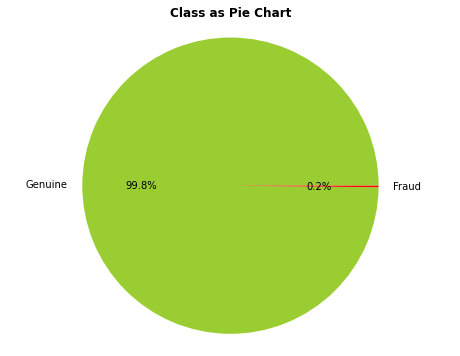

In [6]:
# Check Class variables that has 0 value for Genuine transactions and 1 for Fraud
fig, ax = plt.subplots(1, 1, figsize=(8,6))
ax.pie(df.Class.value_counts(),autopct='%1.1f%%', labels=['Genuine','Fraud'], colors=['yellowgreen','r'])
plt.axis('equal')
plt.title("Class as Pie Chart", fontweight='bold');

#### Histogram

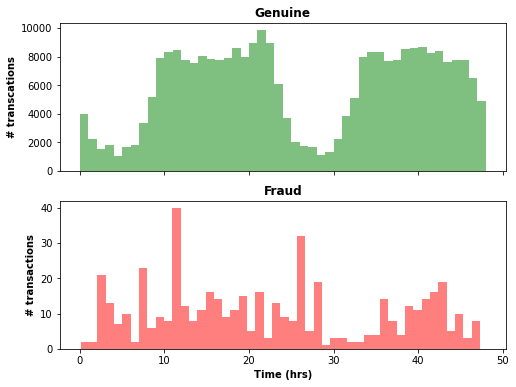

In [7]:
#plot Time to see if there is any trend
df["Time_Hr"] = df["Time"]/3600 # convert to hours
fig, (ax1, ax2) = plt.subplots(2, 1, sharex = True, figsize=(8, 6))
ax1.hist(df.Time_Hr[df.Class==0],bins=48,color='g',alpha=0.5)
ax1.set_ylabel('# transcations', fontweight='bold')
ax1.set_title('Genuine', fontweight='bold')
ax2.hist(df.Time_Hr[df.Class==1],bins=48,color='r',alpha=0.5)
ax2.set_title('Fraud', fontweight='bold')
plt.xlabel('Time (hrs)', fontweight='bold')
plt.ylabel('# transactions', fontweight='bold');



This "Time" feature shows that rate of transactions is picking up during day time. But number of transactions have almost similar dependence on time of the day for both the classes. So, I believe this feature does not yield any predictive power to distinguish between the two classes. But ofcourse I will later test this assumption. For now, I'll keep this feature in data frame. I will drop "Time" but keep "Time_Hr".


In [8]:
df = df.drop(['Time'],axis=1)

Also this amount feature is not on same scale as principle components. So, I'll standardize the values of the 'Amount' feature using StandardScalar and save in data-frame for later use.

Let's scale our Amount Column.

In [9]:
from sklearn.preprocessing import StandardScaler
df['scaled_Amount'] = StandardScaler().fit_transform(df['Amount'].values.reshape(-1,1))
df = df.drop(['Amount'],axis=1) 

In [10]:
df.head() 

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,Time_Hr,scaled_Amount
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.000000,0.244964
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.000000,-0.342475
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,0.000278,1.160686
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.000278,0.140534
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,0.000556,-0.073403


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


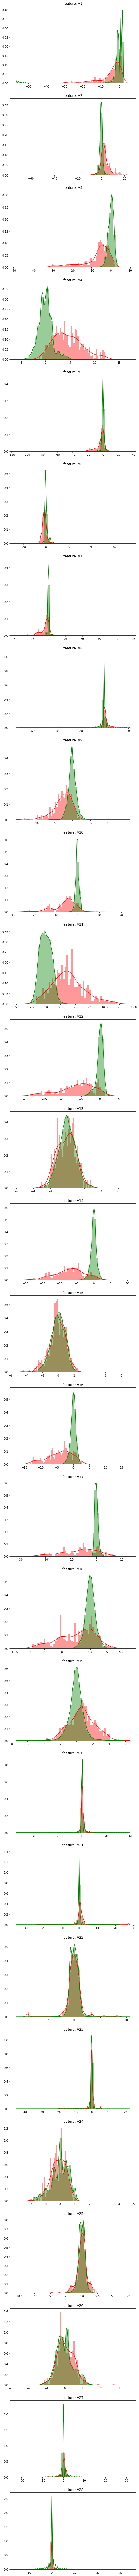

In [11]:
#let us check correlations and shapes of those 25 principal components.
# Features V1, V2, ... V28 are the principal components obtained with PCA.
import seaborn as sns
import matplotlib.gridspec as gridspec
gs = gridspec.GridSpec(28, 1)
plt.figure(figsize=(8,28*6))
for i, col in enumerate(df[df.iloc[:,0:28].columns]):
    ax5 = plt.subplot(gs[i])
    sns.distplot(df[col][df.Class == 1], bins=50, color='r')
    sns.distplot(df[col][df.Class == 0], bins=50, color='g')
    ax5.set_xlabel('')
    ax5.set_title('feature: ' + str(col))
plt.show() 

For some of the features, both the classes have similar distribution. So, I don't expect them to contribute towards classifying power of the model. So, it's best to drop them and reduce the model complexity, and hence the chances of overfitting.


Let's define a train-test split function which will split the data in 80-20 ratio:

In [12]:
def split_data(df, drop_list):
    df = df.drop(drop_list, axis=1)
    #test train split time
    from sklearn.model_selection import train_test_split
    y = df['Class'].values #target
    X = df.drop(['Class'],axis=1).values #features
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20,
                                                    random_state=42, stratify=y)

    print("train-set size: ", len(y_train),
      "\ntest-set size: ", len(y_test))
    return X_train, X_test, y_train, y_test

Let's define a prediction function which will define the classifier, fit the data, predict on test, display predictions:

In [13]:
def get_predictions(clf, X_train, y_train, X_test):
    # create classifier
    clf = clf
    # fit it to training data
    clf.fit(X_train, y_train)
    # predict using test data
    y_pred = clf.predict(X_test)
    # Compute predicted probabilities: y_pred_prob
    y_pred_prob = clf.predict_proba(X_test)
    #for fun: train-set predictions
    train_pred = clf.predict(X_train)
    print('train-set confusion matrix:\n', confusion_matrix(y_train,train_pred)) 
    return y_pred, y_pred_prob

Let's define a print fuction which will print the confusion matrix, recall score, precision, f1 score and accuracy score:

In [14]:
def print_scores(y_test,y_pred,y_pred_prob):
    print('test-set confusion matrix:\n', confusion_matrix(y_test,y_pred))
    print("recall score: ", recall_score(y_test,y_pred))
    print("precision score: ", precision_score(y_test,y_pred))
    print("f1 score: ", f1_score(y_test,y_pred))
    print("accuracy score: ", accuracy_score(y_test,y_pred)) 

##**Gaussian Naive Bayes**

In [15]:
from sklearn.naive_bayes import GaussianNB  

In [16]:
# Case-NB-1 : do not drop anything
drop_list = []
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test, y_pred, y_pred_prob) 

train-set size:  227845 
test-set size:  56962
train-set confusion matrix:
 [[222480   4971]
 [    69    325]]
test-set confusion matrix:
 [[55535  1329]
 [   15    83]]
recall score:  0.8469387755102041
precision score:  0.058781869688385266
f1 score:  0.10993377483443707
accuracy score:  0.9764053228468101


In [17]:
# Case-NB-2 : drop some of principle components that have similar distributions in above plots 
drop_list = ['V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob) 

train-set size:  227845 
test-set size:  56962
train-set confusion matrix:
 [[223967   3484]
 [    61    333]]
test-set confusion matrix:
 [[55935   929]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.08472906403940887
f1 score:  0.15453728661275834
accuracy score:  0.9834802148800955


Clearly, by removing some of the reduntant principle components, I gain in model precision.


In [18]:
# Case-NB-3 : drop some of principle components + Time 
drop_list = ['Time_Hr','V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob) 

train-set size:  227845 
test-set size:  56962
train-set confusion matrix:
 [[223964   3487]
 [    60    334]]
test-set confusion matrix:
 [[55936   928]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.08481262327416174
f1 score:  0.15467625899280577
accuracy score:  0.9834977704434535


As we can see by comapring Case-NB-3 scores with Case-NB-2 scores, "Time_Hr" is not helping much in classification. So, I can remove it safely.
 

In [19]:
# Case-NB-4 : drop some of principle components + Time + 'scaled_Amount'
drop_list = ['scaled_Amount','Time_Hr','V28','V27','V26','V25','V24','V23','V22','V20','V15','V13','V8']
X_train, X_test, y_train, y_test = split_data(df, drop_list)
y_pred, y_pred_prob = get_predictions(GaussianNB(), X_train, y_train, X_test)
print_scores(y_test,y_pred,y_pred_prob) 

train-set size:  227845 
test-set size:  56962
train-set confusion matrix:
 [[224025   3426]
 [    60    334]]
test-set confusion matrix:
 [[55954   910]
 [   12    86]]
recall score:  0.8775510204081632
precision score:  0.08634538152610442
f1 score:  0.15722120658135283
accuracy score:  0.9838137705838981


I would say, Case-NB-4 gives us better model sensitivity (or recall) and precision as compared to Case-NB-1. So dropping some of redundant feature will ofcourse helps to make calculations fast and gain senstivity.


##**Summary**

- We learned how to implement Gaussian Naive Bayes Algorithm
- How dropping some PCA components can improve model performance and avoid overfitting
- Visualize the PCA distribution of all 28 features


##**Reference**
- [GridSpec](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.gridspec.GridSpec.html)
- [Naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)- [GNB](https://www.analyticsvidhya.com/blog/2017/09/naive-bayes-explained/)